In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from random import randint
from uuid import uuid4

data = [str(uuid4()) for i in range(10000)]

# Метрики теста

GMV aggregated (per user, per group)

AVG ratio

Конверсия ratio

In [ ]:
import random
# Конверсия ratio
conv = [randint(0,1) for i in data]

# GMV aggregated (per user, per group)
gmv = [round(random.random()*1000,2)*conv[i] for i in range(len(data))]

# Количество покупок
cnt = [round(random.randint(0,100),2)*conv[i] for i in range(len(data))]

# AVG ratio
avg = [[gmv_i/cnt_i for _ in range(cnt_i)] if cnt_i>=1 else [0] for (gmv_i,cnt_i) in zip(gmv, cnt)]

In [ ]:
df = pd.DataFrame({'user_id': data,
                   'conversion': conv,
                   'gmv': gmv,
                   'cnt': cnt,
                   'avg': avg,})

In [ ]:
df.head(20)

,user_id,conversion,gmv,cnt,avg
0,58cb2166-94ae-4c37-88be-00867977dd4b,0,0.00,0,[0]
1,9fa00a8f-6294-43dd-b04d-8f126903f7bc,1,454.38,7,"[64.91142857142857, 64.91142857142857, 64.9114..."
2,b5c9d064-3083-4d9a-9a4a-47917606ecb2,0,0.00,0,[0]
3,ffda2b31-0456-404a-a31a-dc4301616c01,1,50.66,69,"[0.7342028985507246, 0.7342028985507246, 0.734..."
4,4ac059ad-de39-4912-b3cf-2084494b923c,0,0.00,0,[0]
5,aaa07a9d-0097-4891-9956-0df7f1f5185e,0,0.00,0,[0]
6,0150fedc-e75a-486a-aefd-998c98cf4dd6,0,0.00,0,[0]
7,91486a8d-65d3-459b-806f-6c2f37939759,1,523.28,40,"[13.081999999999999, 13.081999999999999, 13.08..."
8,60630087-412d-4247-8147-a2081feacaec,0,0.00,0,[0]
9,e2dd5eb9-c7d4-4a01-a915-616b80eab098,1,475.22,61,"[7.790491803278689, 7.790491803278689, 7.79049..."


## Bootstrap

In [ ]:
def bootstrap(test, control, iterations = 1000):
  iterations = iterations
  size = min(len(test), len(control))
  t_boots = [random.choices(test, weights=None, k=size) for _ in range(iterations)]
  c_boots = [random.choices(control, weights=None, k=size) for _ in range(iterations)]
  return t_boots, c_boots

In [ ]:
def agg_sum(array):
  return [sum(i) for i in array]

def agg_avg(array):
  return [sum(i)/len(i) for i in array]

In [ ]:
def diff(test, control):
  return [test_i - control_i for (test_i,control_i) in zip(test,control)]

def compare(test, control):
  return [test_i/control_i for (test_i,control_i) in zip(test,control)]

def perc_compare(test, control):
  return [(test_i/control_i-1)*100 for (test_i,control_i) in zip(test,control)]

# 1. Достаточный объём выборки
### 1.1. Per-user-метрика

In [ ]:
random.seed(42)

In [ ]:
df['hash_value'] = df.user_id.apply(lambda i: hash(i)%100)

# Процент из генеральной совокупности
slices = [10,20,30,40,50]
minimum_lift = []
n_items = []
users = []

metric = 'gmv'

for i in slices:
  test_slice = df['hash_value']<i
  control_slice = (df['hash_value']>=i) & (df['hash_value']<2*i)

  test = df[test_slice][metric].to_list()
  control = df[control_slice][metric].to_list()

  t_list, c_list = bootstrap(test, control)

  result = perc_compare(agg_sum(t_list), agg_sum(c_list))
  minimum_lift.append((np.quantile(result, 0.975) - np.quantile(result, 0.025))/2)
  n_items.append(i)
  users.append(min(len(test), len(control)))
t_boots, c_boots = t_list, c_list

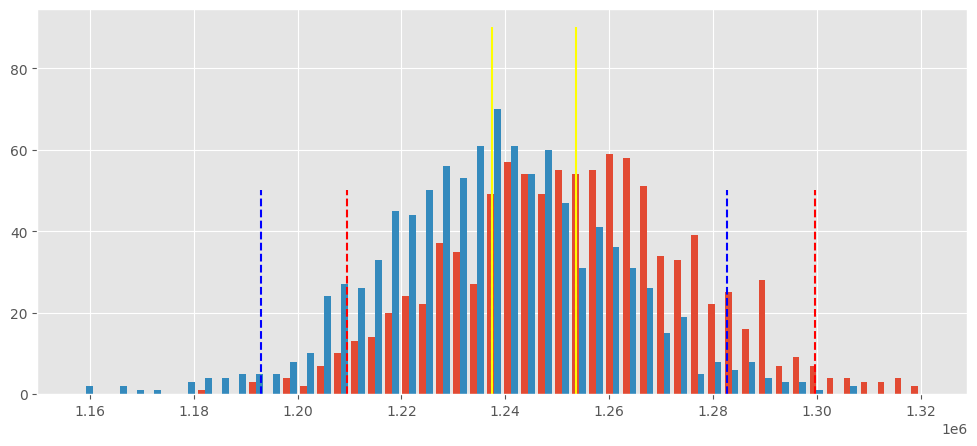

In [ ]:
t = agg_sum(t_boots)
c = agg_sum(c_boots)
plt.figure(figsize=(12,5))
plt.style.use('ggplot')
plt.hist([t,c], bins=50)
plt.vlines([np.quantile(t,q=0.975),np.quantile(t,q=0.025),np.quantile(t,q=0.5)],ymin=0,ymax=50,linestyle='--', color='red')
plt.vlines([np.quantile(c,q=0.975),np.quantile(c,q=0.025),np.quantile(c,q=0.5)],ymin=0,ymax=50,linestyle='--', color='blue')
plt.vlines([np.quantile(t,q=0.5),np.quantile(c,q=0.5)],ymin=0,ymax=90,linestyle='-', color='yellow')
plt.show()

In [ ]:
pd.DataFrame({'minimum_lift': minimum_lift,
'users': users,
'n_items': n_items})

,minimum_lift,users,n_items
0,11.159025,980,10
1,7.592055,1968,20
2,6.363231,2995,30
3,5.296171,3981,40
4,5.004424,4981,50


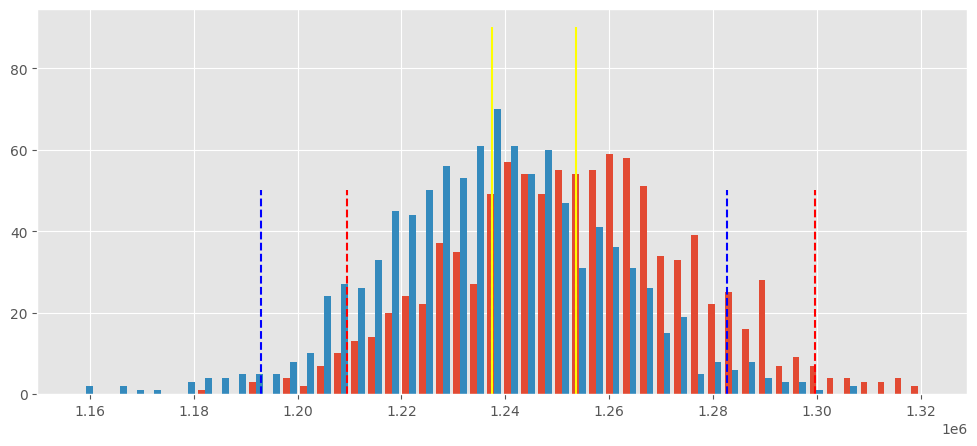

In [ ]:
t = agg_sum(t_boots)
c = agg_sum(c_boots)
plt.figure(figsize=(12,5))
plt.style.use('ggplot')
plt.hist([t,c], bins=50)
plt.vlines([np.quantile(t,q=0.975),np.quantile(t,q=0.025),np.quantile(t,q=0.5)],ymin=0,ymax=50,linestyle='--', color='red')
plt.vlines([np.quantile(c,q=0.975),np.quantile(c,q=0.025),np.quantile(c,q=0.5)],ymin=0,ymax=50,linestyle='--', color='blue')
plt.vlines([np.quantile(t,q=0.5),np.quantile(c,q=0.5)],ymin=0,ymax=90,linestyle='-', color='yellow')
plt.show()

### 1.2. Ratio-метрика
Классический Bootstrap для конверсий

In [ ]:
def bootstrap(test, control, iterations = 1000):
  iterations = iterations
  t_boots = [random.choices(test, weights=None, k=len(test)) for _ in range(iterations)]
  c_boots = [random.choices(control, weights=None, k=len(control)) for _ in range(iterations)]
  return t_boots, c_boots

In [ ]:
df['hash_value'] = df.user_id.apply(lambda i: hash(i)%100)

# Процент из генеральной совокупности
slices = [10,20,30,40,50]
minimum_lift = []
n_items = []
users = []

metric = 'conversion'

for i in slices:
  test_slice = df['hash_value']<i
  control_slice = (df['hash_value']>=i) & (df['hash_value']<2*i)

  test = df[test_slice][metric].to_list()
  control = df[control_slice][metric].to_list()

  t_list, c_list = bootstrap(test, control)

  result = diff(agg_avg(t_list), agg_avg(c_list))
  minimum_lift.append((np.quantile(result, 0.975) - np.quantile(result, 0.025))/2)
  n_items.append(i)
  users.append(min(len(test), len(control)))
t_boots, c_boots = t_list, c_list

In [ ]:
pd.DataFrame({'minimum_lift': minimum_lift,
'users': users,
'n_items': n_items})

,minimum_lift,users,n_items
0,0.045738,980,10
1,0.031455,1968,20
2,0.024458,2995,30
3,0.022030,3981,40
4,0.019497,4981,50


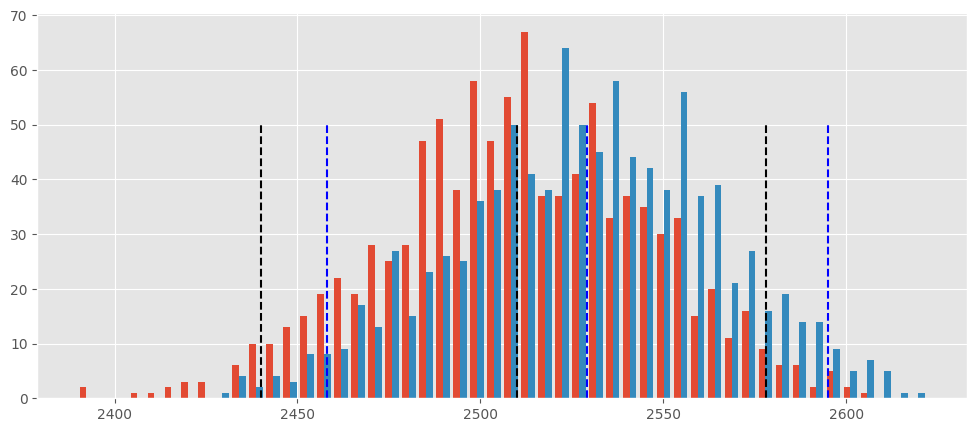

In [ ]:
t = agg_sum(t_boots)
c = agg_sum(c_boots)
plt.figure(figsize=(12,5))
plt.hist([t,c], bins=50)
plt.vlines([np.quantile(t,q=0.975),np.quantile(t,q=0.025),np.quantile(t,q=0.5)],ymin=0,ymax=50,linestyle='--', color='black')
plt.vlines([np.quantile(c,q=0.975),np.quantile(c,q=0.025),np.quantile(c,q=0.5)],ymin=0,ymax=50,linestyle='--', color='blue')
plt.show()

Bootstrap с предварительной линеаризацией для средних чеков на покупку

У нас одно наблюдение - один пользователь, метрики агрегированы на пользователя (например, GMV, количество покупок)
Линеаризация нужна, если на пользователя несколько объектов наблюдения (например, чеков, и мы хотим протестировать средний чек покупки )




In [ ]:
def linearization(control, experiment):
    numerator = 0
    denominator = 0
    for row in control:
        numerator += sum(row)
        denominator += len(row)

    control_mean = numerator / denominator
    new_control = [sum(row) - len(row) * control_mean for row in control]
    new_experiment = [sum(row) - len(row) * control_mean for row in experiment]
    return new_control, new_experiment
new_control, new_experiment = linearization(df[df['hash_value']>=50]['avg'], df[df['hash_value']<50]['avg'])    

In [ ]:
df[df['hash_value']>=50]['avg']

0                                                     [0]
2                                                     [0]
8                                                     [0]
9       [7.790491803278689, 7.790491803278689, 7.79049...
10                                                    [0]
                              ...                        
9993                                                  [0]
9994                                                  [0]
9997    [10.311392405063291, 10.311392405063291, 10.31...
9998    [26.933333333333334, 26.933333333333334, 26.93...
9999    [4.241690140845071, 4.241690140845071, 4.24169...
Name: avg, Length: 5019, dtype: object

In [ ]:
new_control[:10]

[-9.670567894469038,
 -9.670567894469038,
 -9.670567894469038,
 -114.68464156261075,
 -9.670567894469038,
 -33.676691040045,
 -38.58555525110711,
 -9.670567894469038,
 209.1244447488935,
 836.1414815829643]

In [ ]:
# Процент из генеральной совокупности
slices = [10,20,30,40,50]
minimum_lift = []
n_items = []
users = []

metric = 'avg'

for i in slices:
  test_slice = df['hash_value']<i
  control_slice = (df['hash_value']>=i) & (df['hash_value']<2*i)

  control, test = linearization(df[control_slice][metric].to_list(), df[test_slice][metric].to_list())

  t_list, c_list = bootstrap(test, control)

  result = diff(agg_avg(t_list), agg_avg(c_list))
  minimum_lift.append((np.quantile(result, 0.975) - np.quantile(result, 0.025))/2)
  n_items.append(i)
  users.append(min(len(test), len(control)))
t_boots, c_boots = t_list, c_list

In [ ]:
pd.DataFrame({'minimum_lift': minimum_lift, 'n_items': n_items, 'users': users})

,minimum_lift,n_items,users
0,24.618337,10,980
1,16.541470,20,1968
2,14.013003,30,2995
3,11.924746,40,3981
4,11.296712,50,4981


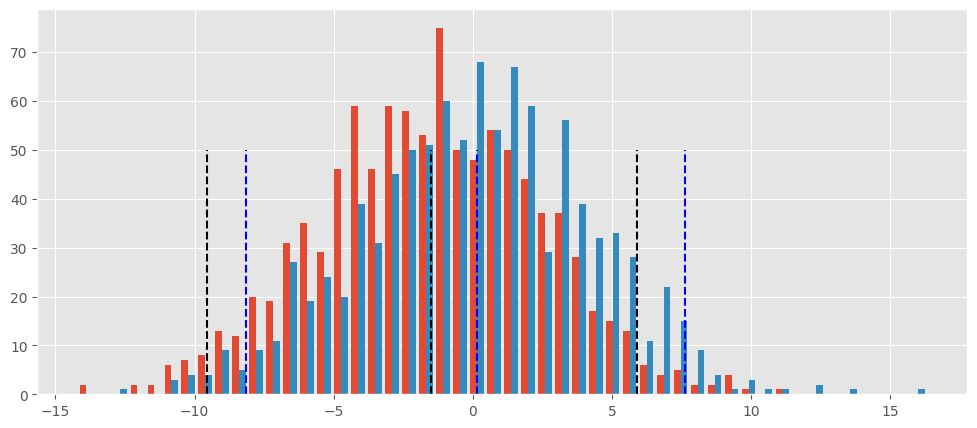

In [ ]:
t = agg_avg(t_boots)
c = agg_avg(c_boots)
plt.figure(figsize=(12,5))
plt.hist([t,c], bins=50)
plt.vlines([np.quantile(t,q=0.975),np.quantile(t,q=0.025),np.quantile(t,q=0.5)],ymin=0,ymax=50,linestyle='--', color='black')
plt.vlines([np.quantile(c,q=0.975),np.quantile(c,q=0.025),np.quantile(c,q=0.5)],ymin=0,ymax=50,linestyle='--', color='blue')
plt.show()

### Моделируем поведение после теста

In [ ]:
# После теста
df2_1 = df[df['hash_value']<50].copy(deep=True)
df2_2 = df[df['hash_value']>=50].copy(deep=True)
n = df2_2.shape[0]
conv = random.choices([0,1], weights=(10, 14), k=n)
gmv = [round(random.random()*2000,2)*conv[i] for i in range(n)]
cnt = [round(random.randint(0,200),2)*conv[i] for i in range(n)]
avg = [gmv_i/cnt_i if cnt_i>=1 else None for (gmv_i,cnt_i) in zip(gmv, cnt)]

df2_2 = pd.DataFrame({'user_id': df2_2.user_id.to_list(),
                   'conversion': conv,
                   'gmv': gmv,
                   'cnt': cnt,
                   'avg': avg,
                   'hash_value': df2_2.hash_value.to_list()})
df2 = pd.concat([df2_1, 
                 df2_2])
del df2_1, df2_2

# 2. Расчет результатов теста
### 2.1. Per-user-метрика

In [ ]:
metric = 'gmv'

test_slice = df2['hash_value']>=50
control_slice = df2['hash_value']<50

test = df2[test_slice][metric].to_list()
control = df2[control_slice][metric].to_list()

t_list, c_list = bootstrap(test, control)

result = perc_compare(agg_sum(t_list), agg_sum(c_list))
ci_all = np.quantile(result, 0.025).round(2), np.quantile(result, 0.975).round(2)
print('CI for ' + f': [{ci_all[0]}; {ci_all[1]}]')


CI for : [124.22; 147.03]


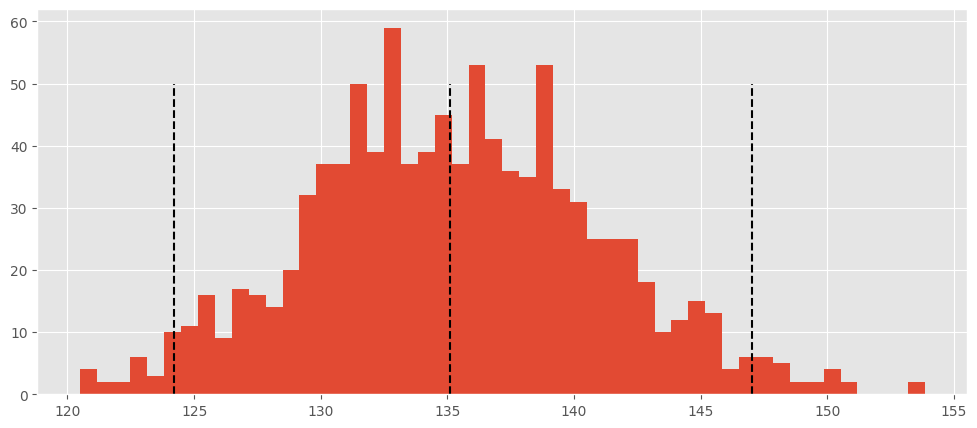

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(result, bins=50)
plt.vlines([np.quantile(result,q=0.975),np.quantile(result,q=0.025),np.quantile(result,q=0.5)],ymin=0,ymax=50,linestyle='--', color='black')
plt.show()

Вывод: Наблюдаем на измененном dataset'е статистически значимые отличия в GMV

In [ ]:
metric = 'gmv'

test_slice = df['hash_value']>=50
control_slice = df['hash_value']<50

test = df[test_slice][metric].to_list()
control = df[control_slice][metric].to_list()

t_list, c_list = bootstrap(test, control)

result = perc_compare(agg_sum(t_list), agg_sum(c_list))
ci_all = np.quantile(result, 0.025).round(2), np.quantile(result, 0.975).round(2)
print('CI for ' + f': [{ci_all[0]}; {ci_all[1]}]')


CI for : [-5.09; 4.55]


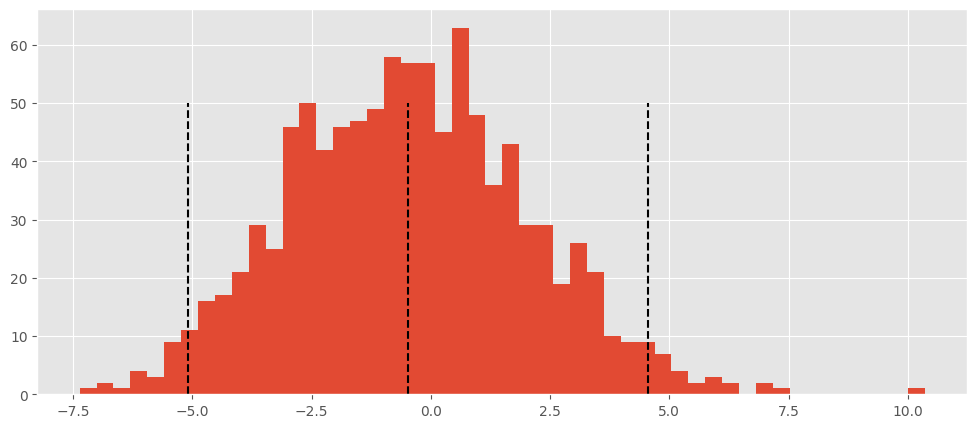

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(result, bins=50)
plt.vlines([np.quantile(result,q=0.975),np.quantile(result,q=0.025),np.quantile(result,q=0.5)],ymin=0,ymax=50,linestyle='--', color='black')
plt.show()

Вывод: на неизмененном dataset'е (без смоделированного uplift'а) не наблюдаем стат. значимых разичий

### 2.2. Ratio-метрика
Классический Bootstrap

In [ ]:
metric = 'conversion'

test_slice = df2['hash_value']>=50
control_slice = df2['hash_value']<50

test = df2[test_slice][metric].to_list()
control = df2[control_slice][metric].to_list()

t_list, c_list = bootstrap(test, control)

result = diff(agg_avg(t_list), agg_avg(c_list))
ci_all = np.quantile(result, 0.025).round(2), np.quantile(result, 0.975).round(2)
print('CI for ' + f': [{ci_all[0]}; {ci_all[1]}]')

CI for : [0.06; 0.1]


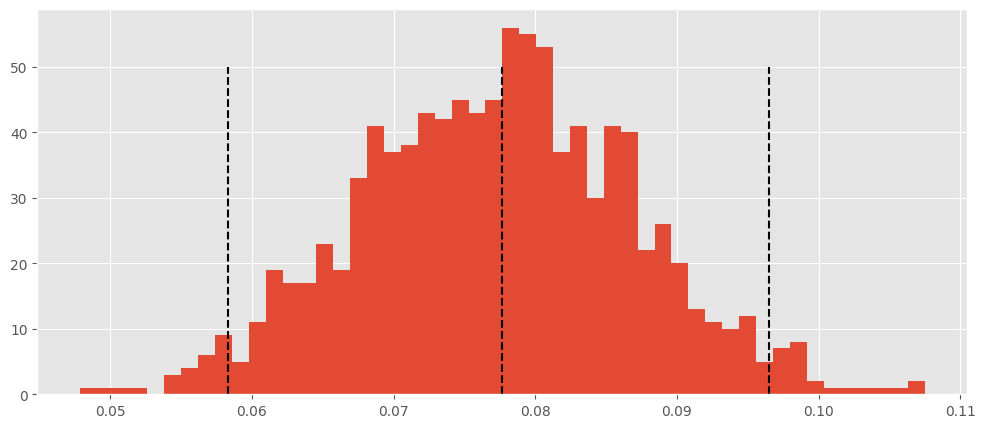

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(result, bins=50)
plt.vlines([np.quantile(result,q=0.975),np.quantile(result,q=0.025),np.quantile(result,q=0.5)],ymin=0,ymax=50,linestyle='--', color='black')
plt.show()

Вывод: на примере метрики конверсии наблюдаем статистически значимые различия

### 3. Сведем расчеты в единую функцию bootstrap

In [ ]:
def bootstrap(test, control, func_agg, func_diff, ratio=False, n_iterations=1000):
    function_agg = func_agg
    function_diff = func_diff
    
    size = min(len(test), len(control))
    t_list = []
    c_list = []
    np.random.seed(seed=42)
    
    for _ in range(n_iterations):
        if ratio:
            test_agg = np.random.choice(a=test, size=len(test), replace=True)
            control_agg = np.random.choice(a=control, size=len(control), replace=True)
        else:
            test_agg = np.random.choice(a=test, size=size, replace=True)
            control_agg = np.random.choice(a=control, size=size, replace=True)
        t_list.append(function_agg(test_agg))
        c_list.append(function_agg(control_agg))
        
    t_list = np.array(t_list)
    c_list = np.array(c_list)
    result = function_diff(t_list, c_list)
    
    ci_all = np.quantile(result, 0.025).round(2), np.quantile(result, 0.975).round(2)
    mde = (np.quantile(result, 0.975) - np.quantile(result, 0.025))/2
    
    return ci_all, mde, result

# Интерпретация: выводы
выводы на стороне аналитика



